# **Projeto Final - Estimação da Pose de um Robô Móvel**

**Alunos:** André Paiva Conrado Rodrigues, Romualdo Oliveira Santos Filho

**Matéria:** ENGG64 - Visão Computacional - 2023.2

## 1 - Importação de dependências e configurações

In [35]:
import numpy as np
import cv2 as cv
import matplotlib as mpl
from matplotlib import pyplot as plt

## 2 - Funções de processamento do vídeo

In [36]:
def extract_frames(filename):

    """Extrai os frames do vídeo."""
    
    frames = []
    video_capture = cv.VideoCapture(filename)
    while True:
        ret, frame = video_capture.read()
        if ret:
            frames.append(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
        else:
            break
    video_capture.release()
    return frames

In [37]:
def gaussian_blur(frames):

    """Aplica desfoque gaussiano em uma
    sequência de frames."""
    
    proc_frames = []
    for frame in frames:
        proc_frame = cv.GaussianBlur(frame, (5, 5), 0)
        proc_frames.append(proc_frame)
    return proc_frames

In [38]:
def color_mask(frames):

    """Segmenta elementos de uma sequência de frames com tonalidades
    próximas do vermelho. Retorna uma imagem binária."""

    proc_frames = []
    for frame in frames:
        mask1 = cv.inRange(cv.cvtColor(frame, cv.COLOR_RGB2HSV), (0, 120, 40), (20, 220, 125))
        mask2 = cv.inRange(cv.cvtColor(frame, cv.COLOR_RGB2HSV), (165, 120, 40), (180, 220, 125))
        mask = cv.bitwise_or(mask1, mask2)
        proc_frames.append(mask)
    return proc_frames

In [39]:
def erode_and_dilate(frames):

    """Erosão e dilatação em imagem binária."""

    proc_frames = []
    kernel_open1 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    kernel_close = cv.getStructuringElement(cv.MORPH_ELLIPSE, (45, 45))
    kernel_open2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
    for frame in frames: 
        proc_frame = cv.morphologyEx(frame, cv.MORPH_OPEN, kernel_open1)
        proc_frame = cv.morphologyEx(proc_frame, cv.MORPH_CLOSE, kernel_close)
        proc_frame = cv.morphologyEx(proc_frame, cv.MORPH_OPEN, kernel_open2)
        proc_frames.append(proc_frame)
        
    return proc_frames

In [40]:
def blob_extractor(frames):

    """Extrai blobs da imagem, os quais devem corresponder a limites
    de área e perímetro estabelecidos."""

    proc_frames = []
    for frame in frames:
        proc_frame = np.zeros(frame.shape, dtype=np.uint8)
        contours, hierarchy = cv.findContours(frame, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        for i, cnt in enumerate(contours):
            if(cv.contourArea(cnt) >= 70 and \
               cv.contourArea(cnt) <= 8000 and \
               cv.arcLength(cnt, True) >= 80):
                cv.drawContours(proc_frame, [cnt], 0, (255), -1)
        proc_frames.append(proc_frame)
    return proc_frames

In [41]:
def centroid(frames):
    
    """Extrai os centroides dos blobs da imagem."""

    centroids = []
    for frame in frames:        
        M = cv.moments(frame)        
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append([cX, cY])
    centroids = np.array(centroids)      
    return centroids

In [42]:
def ellipse(frames):
    
    """Extrai as elipses equivalentes dos blobs da imagem."""

    ellipses = []
    for frame in frames:                
        contours,hierarchy = cv.findContours(frame, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)        
        cnt = contours[0]        
        ellipse = cv.fitEllipse(cnt)
        ellipses.append(ellipse)            
    return ellipses

In [43]:
def uv_plot(list_centroids):
    
    """Gera gráficos de posição do centroide ao longo do tempo."""

    time_axis = np.linspace(0, list_centroids.shape[0]/30, list_centroids.shape[0])
    fig, ax = plt.subplots()
    ax.set_title('Centroide vs. Tempo')
    ax.plot(time_axis, list_centroids[:, 0], color='red', label='u')
    ax.plot(time_axis, list_centroids[:, 1], color='green', label='v')
    ax.set_xlabel('Segundos')
    ax.set_ylabel('Pixels')
    ax.legend()
    return fig

In [44]:
def theta_plot(list_ellipses):

     """Gera gráficos de ângulo do elipse equivalente ao longo do tempo."""

     time_axis = np.linspace(0, len(list_ellipses)/30, len(list_ellipses))
     angulos = [i[2] for i in list_ellipses]
     fig, ax = plt.subplots()
     ax.set_title('Ângulo vs. Tempo')
     ax.plot(time_axis, angulos, color='orange')
     ax.set_xlabel('Segundos')
     ax.set_ylabel('Graus')
     return fig

In [45]:
def path_plot(frame, list_centroids):
    
    """Gera gráfico de trajetória sobre o plano da imagem."""

    fig, ax = plt.subplots()

    ax.set_title('Trajetória')
    ax.invert_yaxis()
    ax.imshow(frame)
    ax.plot(list_centroids[:, 0], list_centroids[:, 1], color='red')
    ax.set_xlabel('u')
    ax.set_ylabel('v')
    return fig

In [46]:
def composite_plot(frames,
                   list_centroids,
                   list_ellipses):
    # FUNÇÃO PARA PLOT COMPOSTO
    # IMPLEMENTAR
    pass

In [47]:
def write_video(frames, filename='output'):

    """Grava uma sequência de frames em um
    arquivo de vídeo."""

    out = cv.VideoWriter('output/' + filename + '.avi',
                         cv.VideoWriter_fourcc(*'MJPG'),
                         30,
                         (frames[0].shape[1], frames[0].shape[0]))
    if len(frames[0].shape) == 2:
        conversion = cv.COLOR_GRAY2BGR
    else:
        conversion = cv.COLOR_RGB2BGR
    for frame in frames:
        out.write(cv.cvtColor(frame, conversion))
    out.release()

In [48]:
def write_plot(fig, filename='output'):

    """Grava plot matplotlib em arquivo PNG."""
    
    fig.savefig('output/' + filename + '.png', dpi=200)

In [49]:
def full_processing(filename):

    # FUNÇÃO PARCIALMENTE IMPLEMENTADA

    """Efetua todos os passos de processamento
    em um determinado arquivo de vídeo, gerando
    representações intermediárias e gráficos
    do processamento."""

    name = filename.split('/')[-1].split('.')[0]
    frames = extract_frames(filename)
    gaussian_frames = gaussian_blur(frames)
    color_seg = color_mask(gaussian_frames)
    eroded_and_dilated = erode_and_dilate(color_seg)
    blobbed = blob_extractor(eroded_and_dilated)
    centroids = centroid(blobbed)
    ellipses = ellipse(blobbed)
    fig_uv = uv_plot(centroids)
    fig_theta = theta_plot(ellipses)
    fig_path = path_plot(frames[0], centroids)
    
    write_plot(fig_uv, name + '-uvplot')
    write_plot(fig_theta, name + '-thetaplot')
    write_plot(fig_path, name + '-pathplot')

    write_video(gaussian_frames, name + '-01-GaussianBlur')
    write_video(color_seg, name + '-02-ColorSegmentation')
    write_video(eroded_and_dilated, name + '-03-ErosionAndDilation')
    write_video(blobbed, name + '-04-BlobExtraction')

## 3 - Aplicação das funções

### 3.1 - Vídeo 1

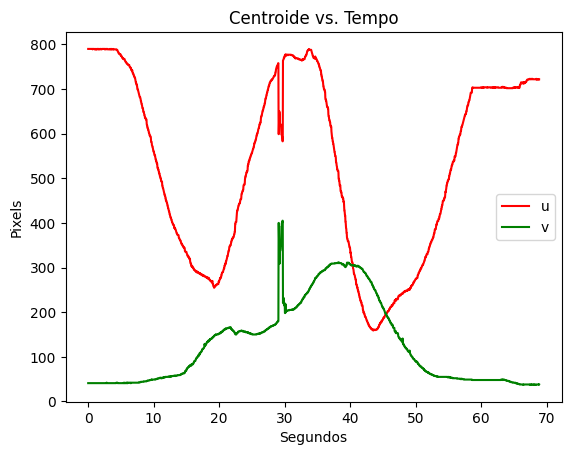

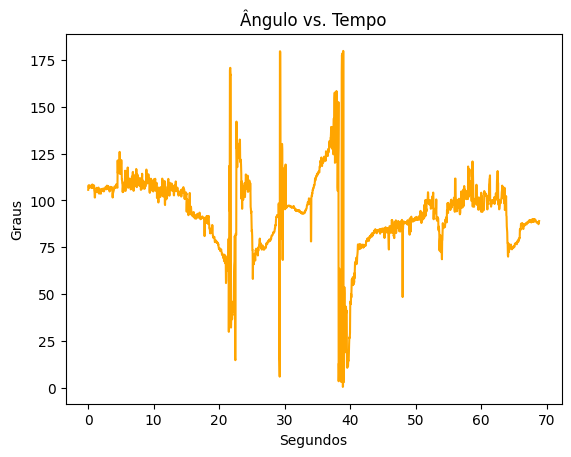

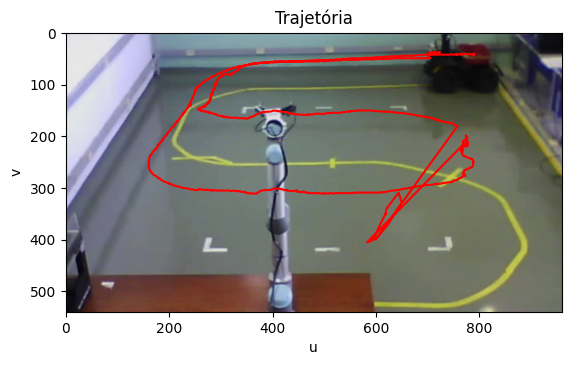

In [50]:
full_processing("images/Video1_husky.mp4")

### 3.2 - Vídeo 2

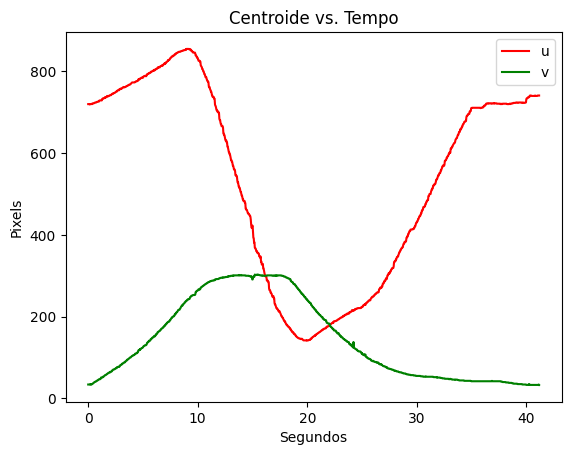

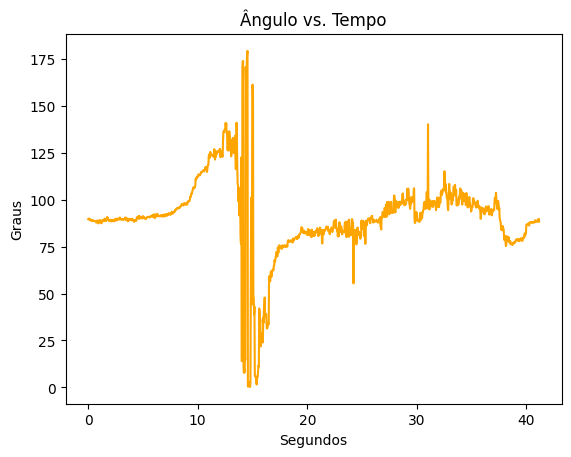

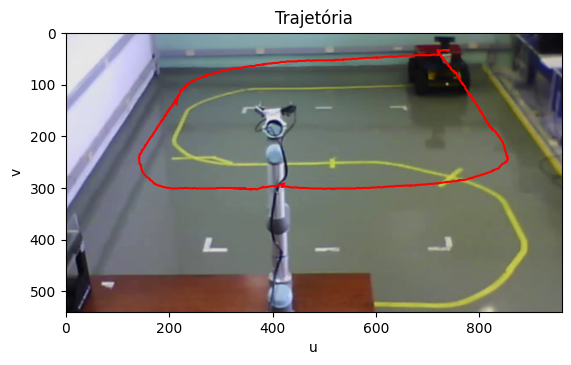

In [51]:
teste = full_processing("images/video2_husky.mp4")